In [1]:
using Bootstrap
using ColorSchemes
using CSV
using DataFrames
using Dates
using ImageFiltering
using Measures
using Measurements
using Plots
using Plots: px
using Statistics
using StatsPlots
using Unitful

Load some basic utility code

In [2]:
rootfolder = normpath(joinpath(@__DIR__, "..", "..", "..", ".."))
include(joinpath(rootfolder, "figures", "utils.jl"))

Load CSV from disk and load the volume measurements with the associated error
and add the XY resolution

In [3]:
types = Dict([:rel_volume, :abs_volume_um3] .=> Measurement{Float64})
linked = CSV.File(joinpath(rootfolder, "data", "fxm_uncaging_augmented.csv"), types = types) |> DataFrame
filter!(x->x.isencapsulated, linked);
# This value was computed manually for our 20x objective
linked.xunit = linked.x .* 0.653u"μm"
linked.yunit = linked.y .* 0.653u"μm";
linked.time = uconvert.(u"minute", linked.time_s .* u"s");
linked.reltime = linked.time .- 15u"minute"; # uncaging always happens at 15 minutes in

Compute instantaneous velocity

In [4]:
"""
Computes instantaneous velocity
"""
function velocity(x::A, y::A, t::B) where {A <: AbstractVector{T1}, B<: AbstractVector{T2}} where {T1, T2}
    (length(x) <= 2) && return fill(NaN * unit(T1) / unit(T2), length(x))
    vs = sqrt.(diff(x) .^ 2 .+ diff(y) .^ 2) ./ diff(t)
    [NaN * unit(T1) / unit(T2), mean(hcat(vs[1:end-1], vs[2:end]), dims =2)..., NaN * unit(T1) / unit(T2)]
end

"""
Compute velocity over some time window `τ`
"""
function velocity(x::A, y::A, t::B, τ) where {A <: AbstractVector{T1}, B<: AbstractVector{T2}} where {T1, T2}
    ν = fill(NaN * unit(T1) / unit(T2), length(x))
    (length(x) <= 2) && return ν

    for i in τ+1:length(x)-τ
        ν[i] = sqrt( (x[i+τ] - x[i-τ])^2 + (y[i+τ] - y[i-τ])^2) / (t[i+τ] - t[i-τ])
    end
    ν
end

transform!(groupby(linked, [:condition, :date, :particle, :dish]),
    [:xunit, :yunit, :time] => velocity => :ν,
    [:xunit, :yunit, :time] => ((x, y, t) -> velocity(x,y,t,1)) => :ν₁,
    [:xunit, :yunit, :time] => ((x, y, t) -> velocity(x,y,t,2)) => :ν₂,
    [:xunit, :yunit, :time] => ((x, y, t) -> velocity(x,y,t,3)) => :ν₃,
);

speeds = filter(x->all(isfinite.([x.ν, x.ν₁, x.ν₂, x.ν₃])), linked);

### Compute median velocity for each time point in a run

In [5]:
med_velocities = combine(groupby(speeds, [:reltime, :condition, :date, :dish]),
    :ν => (x->length(x) > 10 ? ustrip.(median(x)) : NaN) => :med_ν,
    :ν₁ => (x->length(x) > 10 ? ustrip.(median(x)) : NaN) => :med_ν₁,
    :ν₂ => (x->length(x) > 10 ? ustrip.(median(x)) : NaN) => :med_ν₂,
    :ν₃ => (x->length(x) > 10 ? ustrip.(median(x)) : NaN) => :med_ν₃,
    :ν => length => :n);

Filter out a flow spike in one of the sample

In [6]:
filter!(x->!(x.condition == "Duvel" && x.date == Date(2023, 3, 10) && -3.5u"minute" <= x.reltime <= -2.25u"minute"), med_velocities)

filter!(x->all(isfinite.([x.med_ν, x.med_ν₁, x.med_ν₂, x.med_ν₃])), med_velocities);

### Bootstrap within conditions to determine confidence intervals

Here we bootstrap to determine the 95% confidence intervals for each time
point and condition. This gives us an understanding for how much any given run
affects our overall conclusions.

In [7]:
med_ν_mean = combine(groupby(med_velocities, [:reltime, :condition]),
                            :med_ν => (x->NamedTuple{(:ν_μ, :ν_l, :ν_u)}(confint(bootstrap(mean, x, BasicSampling(1_000)), BasicConfInt(0.95))[1])) => AsTable,
                            :med_ν₁ => (x->NamedTuple{(:ν₁_μ, :ν₁_l, :ν₁_u)}(confint(bootstrap(mean, x, BasicSampling(1_000)), BasicConfInt(0.95))[1])) => AsTable,
                            :med_ν₂ => (x->NamedTuple{(:ν₂_μ, :ν₂_l, :ν₂_u)}(confint(bootstrap(mean, x, BasicSampling(1_000)), BasicConfInt(0.95))[1])) => AsTable,
                            :med_ν₃ => (x->NamedTuple{(:ν₃_μ, :ν₃_l, :ν₃_u)}(confint(bootstrap(mean, x, BasicSampling(1_000)), BasicConfInt(0.95))[1])) => AsTable,
                            :med_ν => length => :n,
);

### Plot function

In [8]:
cmap = Dict("WT" => okabe_ito[1], "BIX" => okabe_ito[2], "Duvel" => okabe_ito[4], "BIXOSMO" => okabe_ito[8], "LatB" => okabe_ito[5])

function velocity_plot(df)
    sort!(df, [:reltime, :condition])
    vspan([2.5u"minute", 30u"minute"], alpha = 0.5, c = colorant"lightgray")
    vspan!([0.5u"minute", 2.5u"minute"], label = "", alpha = 0.3, c = okabe_ito[8])
    p = @df df plot!(:reltime,
        :ν₃_μ, group = :condition, ribbon = (:ν₃_μ .- :ν₃_l, :ν₃_u .- :ν₃_μ),
        ylabel = "Cell velocity (μm/min)", xlabel = P"Time (mins)", xticks = collect(-10:10:30),
        yticks = 0:2:10,
        framestyle = :axes, grid = :y, xlim = (-10, 30), ylim = (0, 10.5),
        tick_direction = :out, #leg = :outerright,
        topmargin = 5mm, rightmargin = 15mm,
        linewidth = 2, c = getindex.(Ref(cmap), :condition), leg = false, margin = 25px,
        size = (530, 400))
    vspan!([0, 0.5], label = "", alpha = 0.5, c = colorant"purple")
    annotate!(-0.3, 9, text("fMLP\nuncage", :black, :right, 8))
    ("WT" in df.condition) && annotate!(30.5, 7.5, text("Ctrl", "Helvetica Bold", okabe_ito[1], :left, 10))
    ("BIXOSMO" in df.condition) && annotate!(30.5, 6, text("iNHE1\n+Osmo", "Helvetica Bold", okabe_ito[8], :left, 10))
    ("BIX" in df.condition) && annotate!(30.5, 3.9, text("iNHE1", "Helvetica Bold", okabe_ito[2], :left, 10))
    ("Duvel" in df.condition) && annotate!(30.5, 2.3, text("iPI3Kγ", "Helvetica Bold", okabe_ito[4], :left, 10))
    ("LatB" in df.condition) && annotate!(30.5, 1.0, text("LatB", "Helvetica Bold", okabe_ito[5], :left, 10))
    annotate!(3.5, 9, text("migrating", "Helvetica Bold", colorant"gray", :left, 10))
    annotate!(1.5, 11, text("spreading", "Helvetica Bold", RGBA(okabe_ito[8], 0.5), :center, 10))
    p
end

velocity_plot (generic function with 1 method)

### Plot all

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket application

GKS: Open failed in routine OPEN_WS
GKS: GKS not in proper state. GKS must be either in the state WSOP or WSAC in routine ACTIVATE_WS


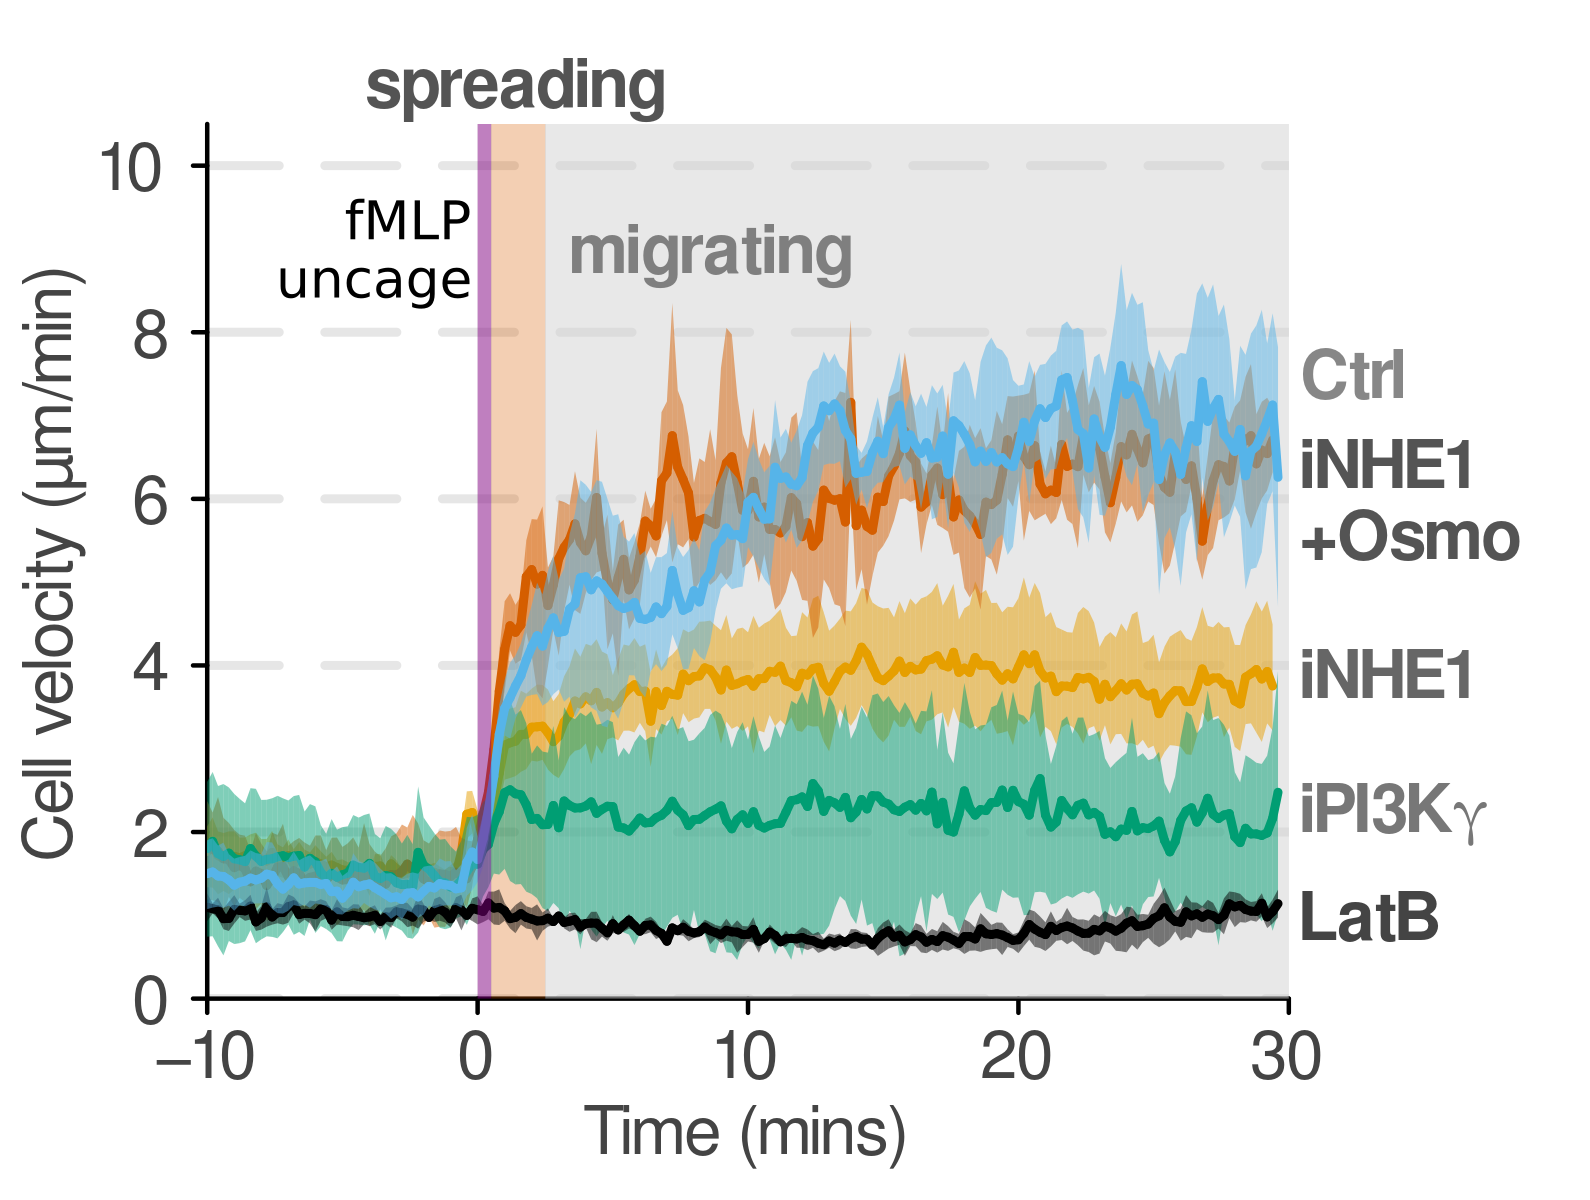

In [9]:
p = velocity_plot(med_ν_mean)
savefig(p, joinpath("assets", "motility.svg"))
p

### Plot hypoosmotic shock rescue

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket application

GKS: Open failed in routine OPEN_WS
GKS: GKS not in proper state. GKS must be either in the state WSOP or WSAC in routine ACTIVATE_WS


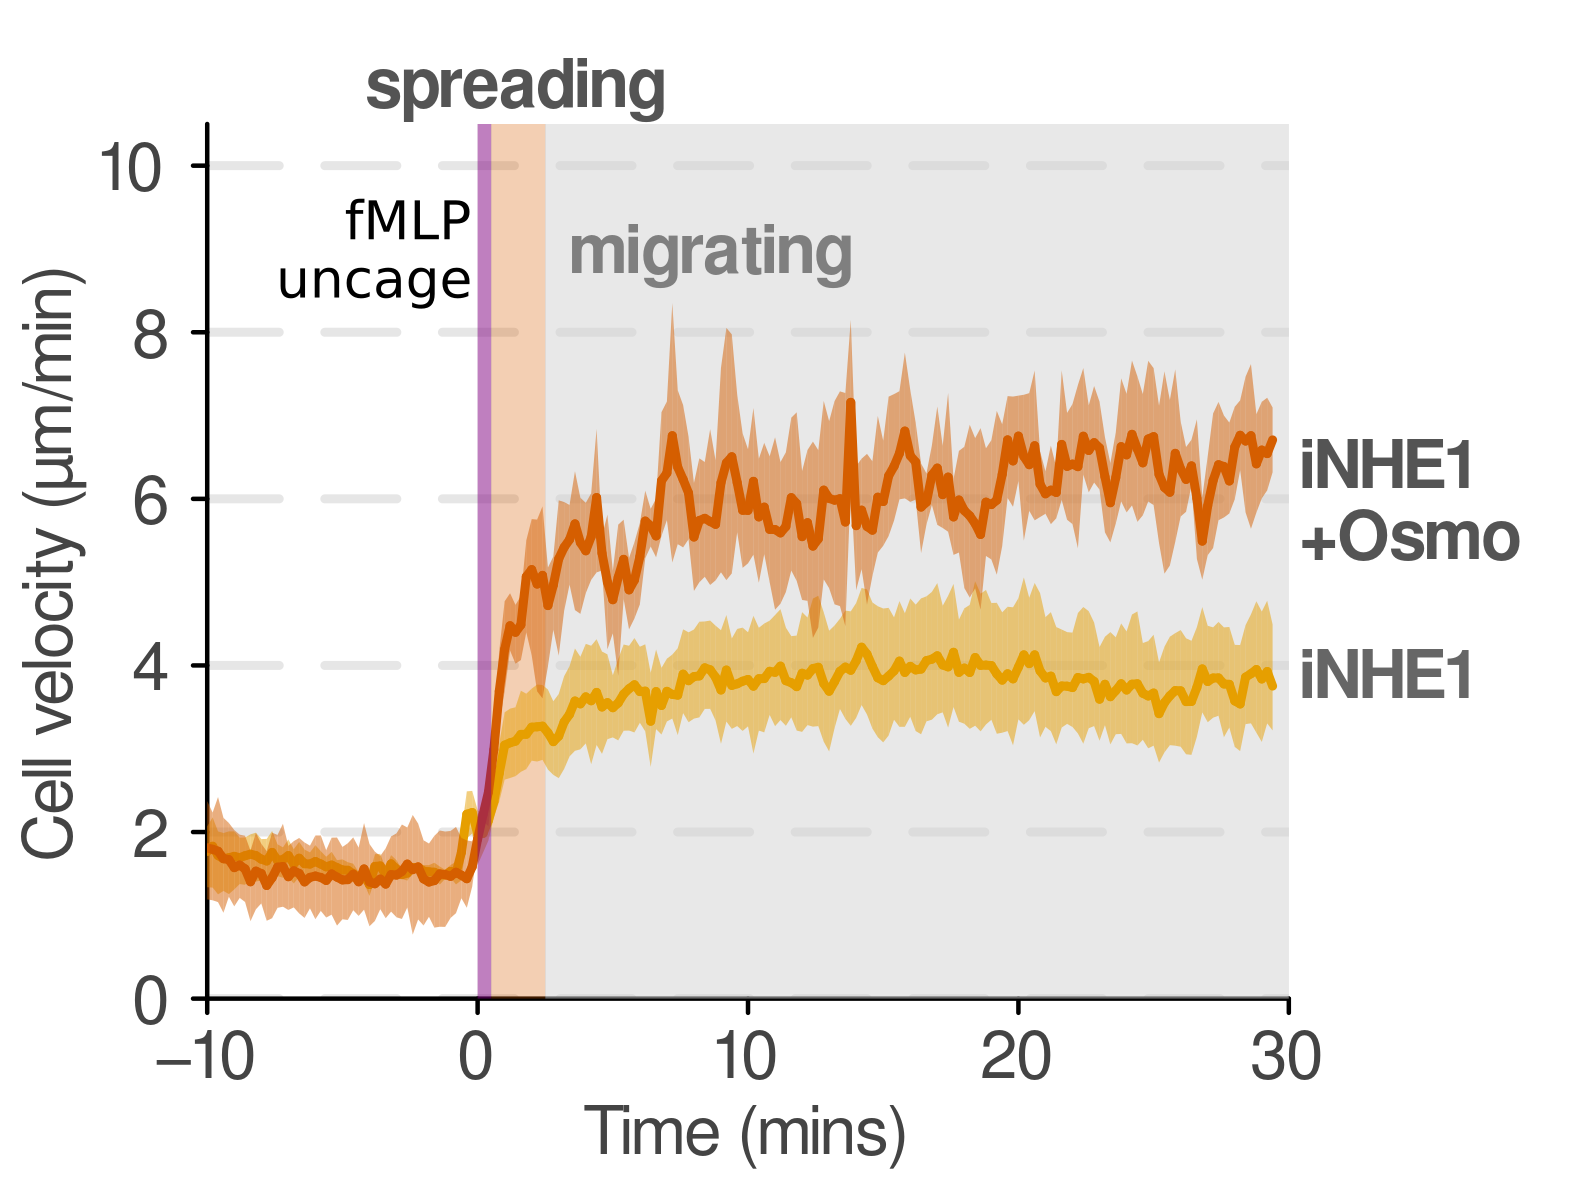

In [10]:
p = velocity_plot(filter(x->x.condition in ["BIX", "BIXOSMO"], med_ν_mean))
savefig(p, joinpath("assets", "bix_v_bixosmo_motility.svg"))
p

### Plot LatB affect on motility

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket application

GKS: Open failed in routine OPEN_WS
GKS: GKS not in proper state. GKS must be either in the state WSOP or WSAC in routine ACTIVATE_WS


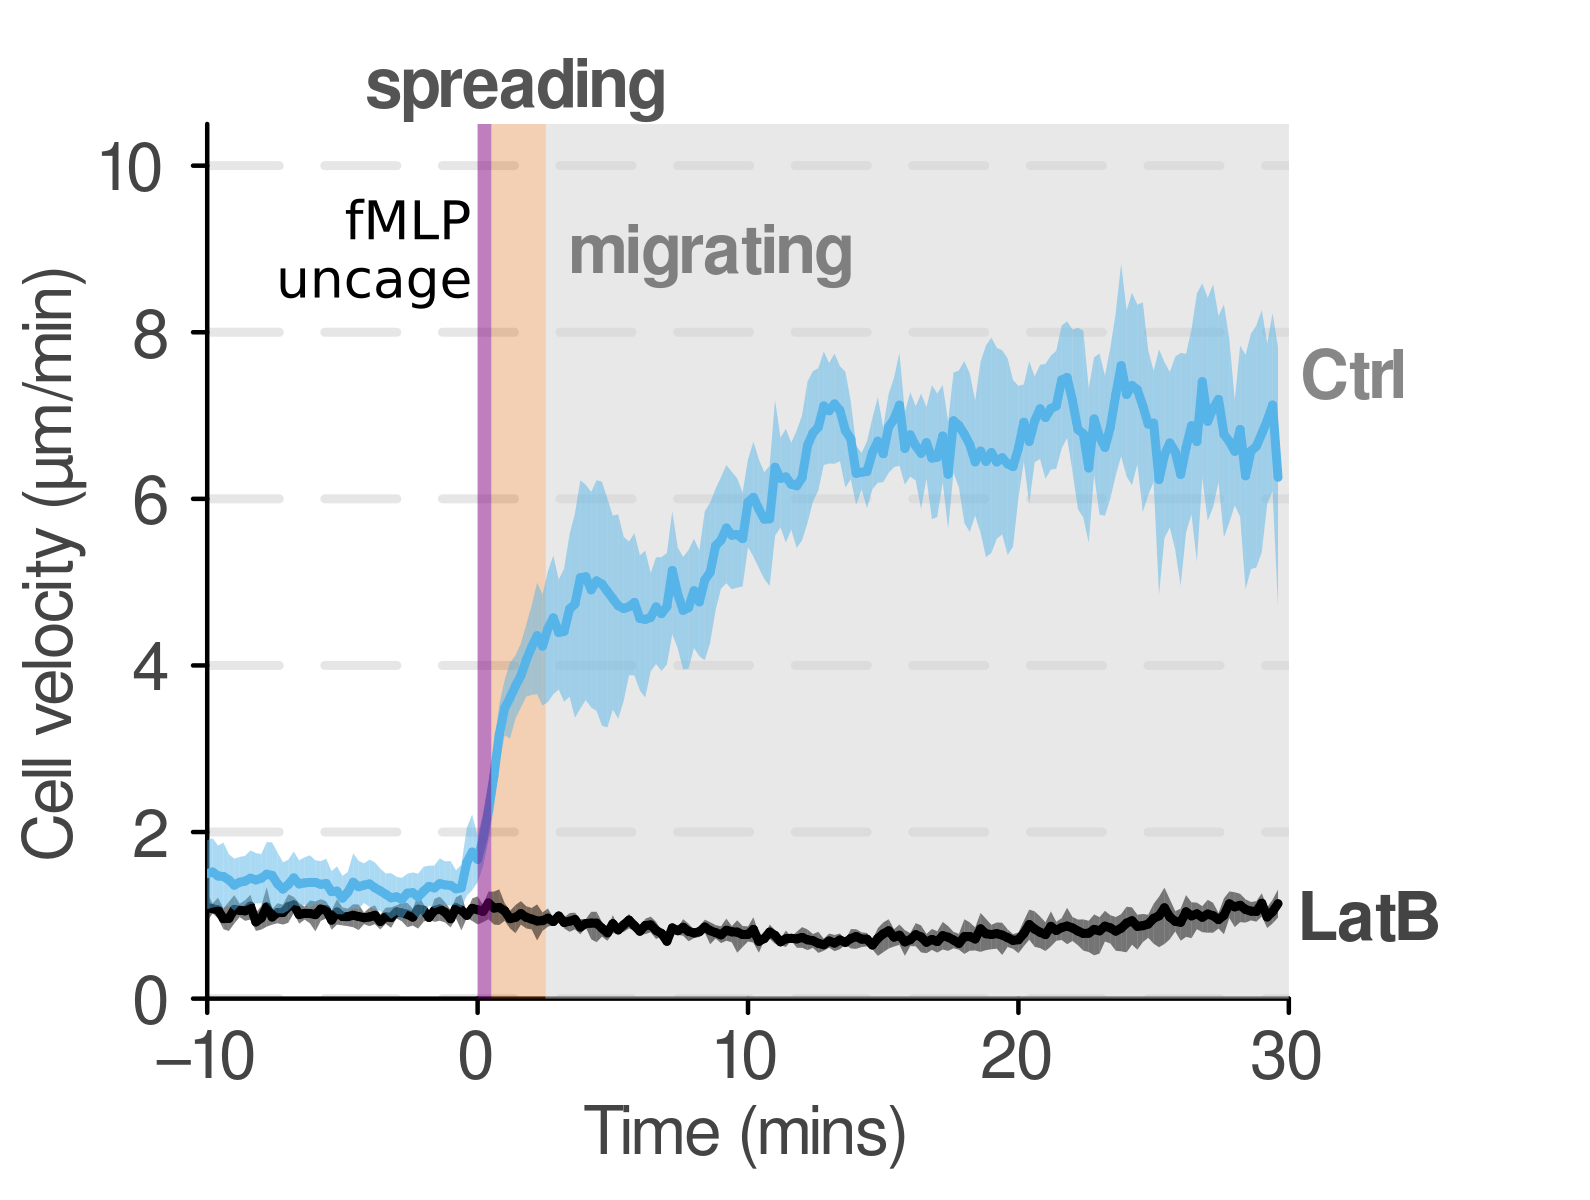

In [11]:
p = velocity_plot(filter(x->x.condition in ["WT", "LatB"], med_ν_mean))
savefig(p, joinpath("assets", "latb_motility.svg"))
p

### Plot inhibition of PI3Kγ affect on motility

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket application

GKS: Open failed in routine OPEN_WS
GKS: GKS not in proper state. GKS must be either in the state WSOP or WSAC in routine ACTIVATE_WS


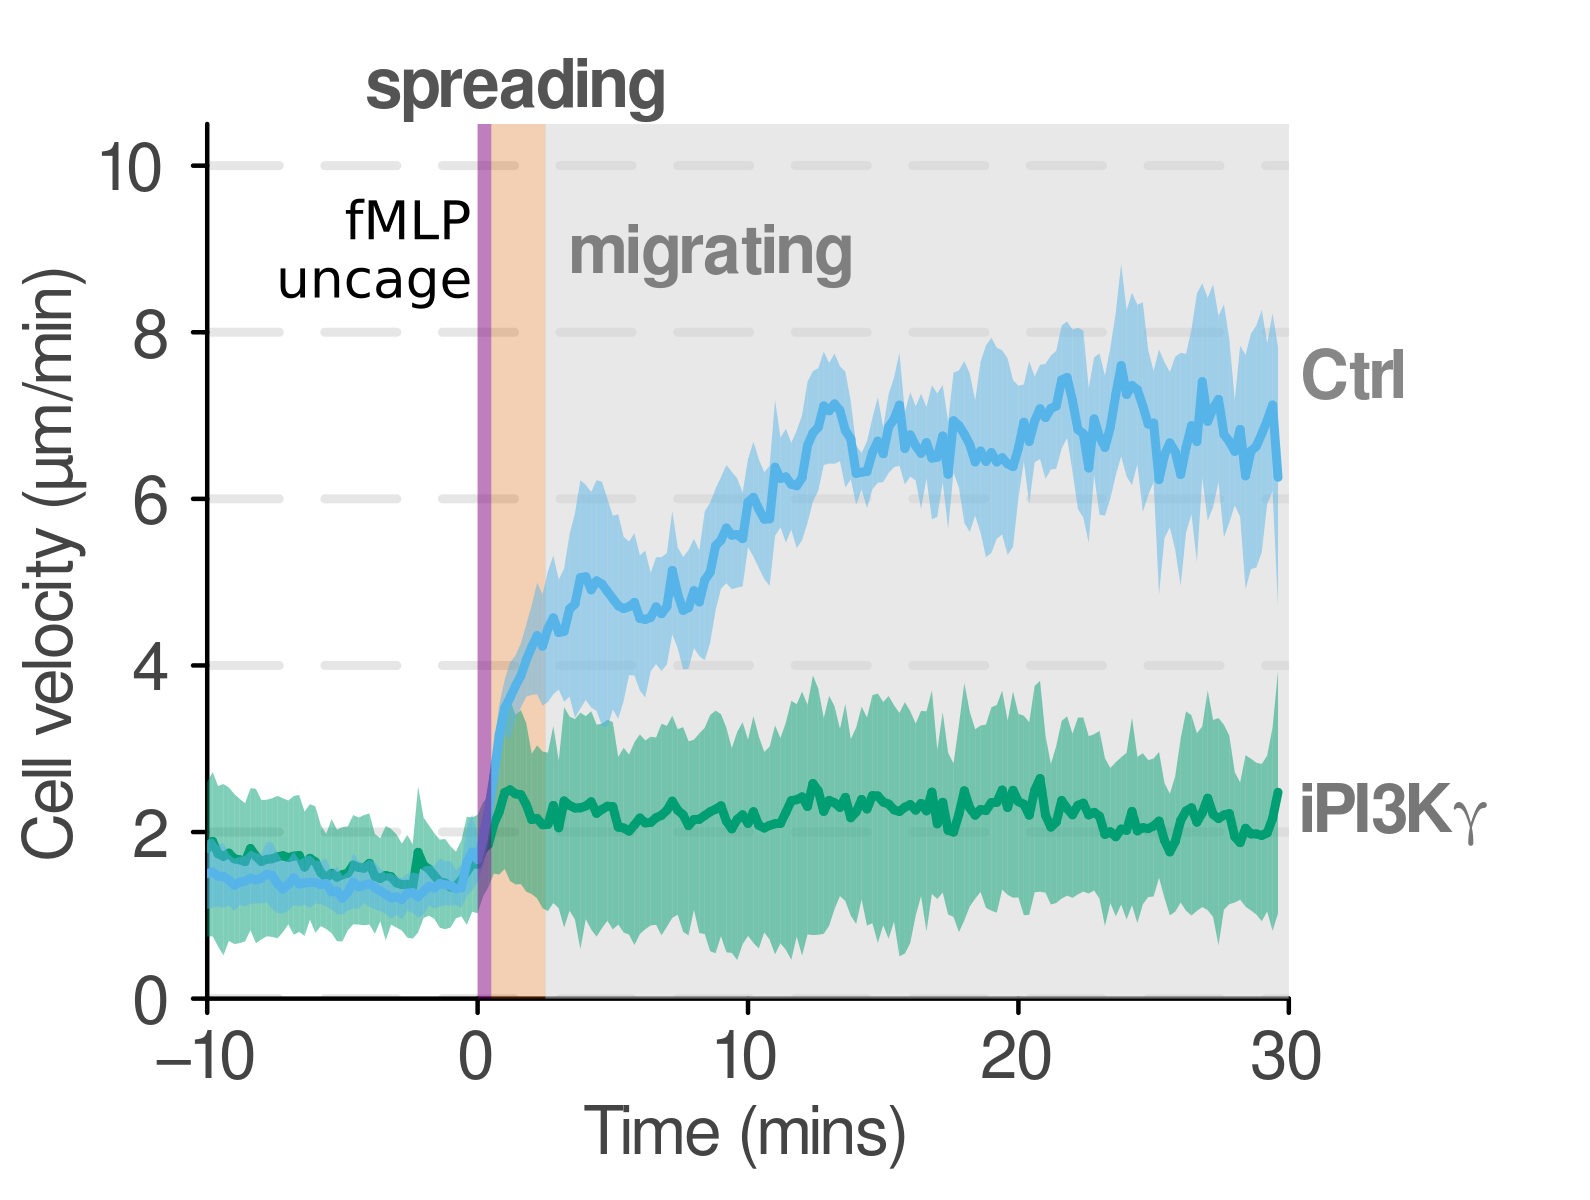

In [12]:
p = velocity_plot(filter(x->x.condition in ["WT", "Duvel"], med_ν_mean))
savefig(p, joinpath("assets", "duvel_motility.svg"))
p

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*